In [2]:
import numpy as np
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.optim import Optimizer
from torch.utils.data import Dataset, DataLoader

In [3]:
NoP = 1000#1000 #NumberOfParticles per set

Norm = np.random.normal(0, 1, NoP)
Normy = np.random.normal(0, 1, NoP)
t = np.random.uniform(0,1,NoP)
x = np.sqrt(t)*np.cos(4*np.sqrt(t)*np.pi)+0.05*Norm
y = np.sqrt(t)*np.sin(4*np.sqrt(t)*np.pi)+0.05*Normy
target = np.zeros((1, NoP))

Norm2 = np.random.normal(0, 1, NoP)
Norm2y = np.random.normal(0, 1, NoP)
t2 = np.random.uniform(0,1,NoP)
x2 = np.sqrt(t2)*np.cos(4*np.sqrt(t2)*np.pi+np.pi)+0.05*Norm2
y2 = np.sqrt(t2)*np.sin(4*np.sqrt(t2)*np.pi+np.pi)+0.05*Norm2y
target2 = np.ones((1, NoP))



DataSet = np.zeros((3,NoP*2))
Data_X = np.hstack((x, x2))
Data_Y = np.hstack((y, y2))
Data = np.vstack((Data_X,Data_Y))
Target = np.hstack((target,target2))
DataSet[0:2,:] = Data
DataSet[2,:] = Target
DataSet = DataSet.T
np.random.shuffle(DataSet)

Split = round((NoP*2)*0.05)
TrainData = DataSet[0:Split,:]
TestData = DataSet[Split:,:]


class CustomDataset:
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = self.data[idx][:2]  # Extract input features
        target = self.data[idx][2]  # Extract target
        return features, target

TrainDataSet = CustomDataset(TrainData)
TestDataSet = CustomDataset(TestData)
TrainDataSet = CustomDataset(TrainData.astype(np.float32))
TestDataSet = CustomDataset(TestData.astype(np.float32))

train_loader = DataLoader(TrainDataSet, batch_size=2, shuffle=True)
test_loader = DataLoader(TestDataSet, batch_size=1900, shuffle=False)

In [3]:
NoP = 1000#1000 #NumberOfParticles per set
DataSet = np.load('NN_Swiss_DataSet.npy')
Split = round((NoP*2)*0.05)
TrainData = DataSet[0:Split,:]
TestData = DataSet[Split:,:]
class CustomDataset:
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = self.data[idx][:2]  # Extract input features
        target = self.data[idx][2]  # Extract target
        return features, target

TrainDataSet = CustomDataset(TrainData)
TestDataSet = CustomDataset(TestData)

TrainDataSet = CustomDataset(TrainData.astype(np.float32))
TestDataSet = CustomDataset(TestData.astype(np.float32))

train_loader = DataLoader(TrainDataSet, batch_size=2, shuffle=True)
test_loader = DataLoader(TestDataSet, batch_size=1900, shuffle=False)

In [4]:
import torch.nn as nn
 
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 500)
        self.relu = nn.ReLU()
        self.output = nn.Linear(500, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
    
model = Wide()

In [5]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)#, momentum=0.9)
loss_fn = nn.BCELoss()

In [6]:
def train_one_epoch(epoch_index):#, tb_writer):
    running_loss = 0.
    last_loss = 0.
    avgg_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        outputs = torch.squeeze(outputs)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        """
        if i % 2 == 1:
      
            last_loss = running_loss / 2 # loss per batch
            avgg_loss += last_loss
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            #tb_x = epoch_index * len(training_loader) + i + 1
            #tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
        """
    running_loss/100    
    return running_loss

In [7]:
epoch_number = 0

 
EPOCHS = 5000
loss_graph = np.zeros((2,EPOCHS))
loss_graph2 = np.zeros((2,EPOCHS))
acc_graph = np.zeros((2,EPOCHS))
acc2_graph = np.zeros((2,EPOCHS))

for epoch in range(EPOCHS):
    #print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)
    loss_graph[0,epoch] = epoch
    loss_graph[1,epoch] = avg_loss

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    
    model.eval()
    acc2 = 0
    acc2_graph[0,epoch] = epoch
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            voutputs = torch.squeeze(voutputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
            predictions2 = (voutputs >= 0.5).int()
            acc2 += (predictions2 == vlabels).sum().item()

    avg_vloss = running_vloss / (i + 1)
    loss_graph2[0,epoch] = epoch
    loss_graph2[1,epoch] = avg_vloss
    acc2_graph[1,epoch] = acc2/1900
    
    
    running_loss = 0.0
    acc_graph[0,epoch] = epoch
    acc = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(train_loader):
            inputs, labels = data
            outputs = model(inputs)
            outputs = torch.squeeze(outputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss
            predictions = (outputs >= 0.5).int()
            acc += (predictions == labels).sum().item()
            
    avg_loss = running_loss / (i + 1)
    loss_graph[0,epoch] = epoch
    loss_graph[1,epoch] = avg_loss        
    acc_graph[1,epoch] = acc/100
    
    
    #print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    #print('LOSS train {} '.format(avg_loss))

    # Log the running loss averaged per batch
    # for both training and validation
    #writer.add_scalars('Training vs. Validation Loss',
    #                { 'Training' : avg_loss, 'Validation' : avg_vloss },
    #                epoch_number + 1)
    #writer.flush()

    # Track best performance, and save the model's state
    #if avg_vloss < best_vloss:
    #    best_vloss = avg_vloss
    #    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    #    torch.save(model.state_dict(), model_path)

    epoch_number += 1

In [147]:
acc2/1900

0.8605263157894737

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


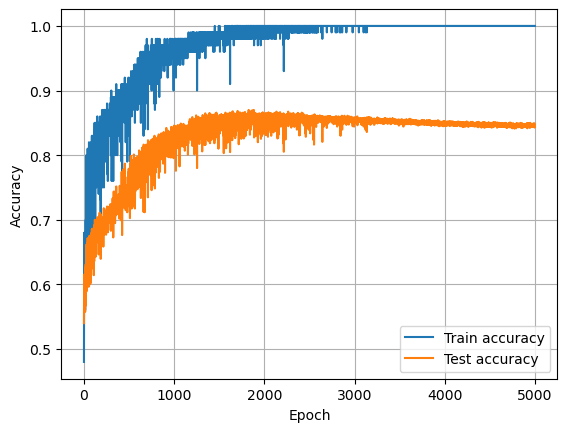

In [17]:
import numpy as np
import matplotlib.pyplot as plt

"""
plt.plot(x_lin,accuracy_graph[:,0,0,0])
plt.plot(x_lin,accuracy_graph[:,1,0,0])
plt.plot(x_lin,accuracy_graph[:,2,0,0])
plt.plot(x_lin,accuracy_graph[:,3,0,0])
plt.plot(x_lin,accuracy_graph[:,4,0,0])
"""
plt.plot(acc_graph[0,:],acc_graph[1,:],label=r'Train accuracy')
plt.plot(acc2_graph[0,:],acc2_graph[1,:],label=r'Test accuracy')

#plt.plot(loss_graph[0,:],loss_graph[1,:],label=r'Train loss')
#plt.plot(loss_graph2[0,:],loss_graph2[1,:],label=r'Test loss')


plt.legend()
plt.xlabel('Epoch')
#plt.ylabel('Loss')
plt.ylabel('Accuracy')
plt.grid(True)
#plt.savefig('NeuralNetworkFigures/SGD_NN_Acc.eps', format='eps')  
plt.show()

In [18]:
points = 300
x_lin = np.linspace(-1.1, 1.1, num=points)
y_lin = np.linspace(-1.1, 1.1, num=points)

span = np.zeros((2,points**2))
tar = np.zeros((points**2))

for i in range(points):   
    x = x_lin[i]
    for j in range(points):
        ind = i*points + j
        y = y_lin[j]
        span[:,ind] = np.array([x,y])

temp = torch.from_numpy(span.astype(np.float32))        

for i in range(points**2):
    test = model.forward(temp[:,i])
    tar[i] = test[0]
    
    

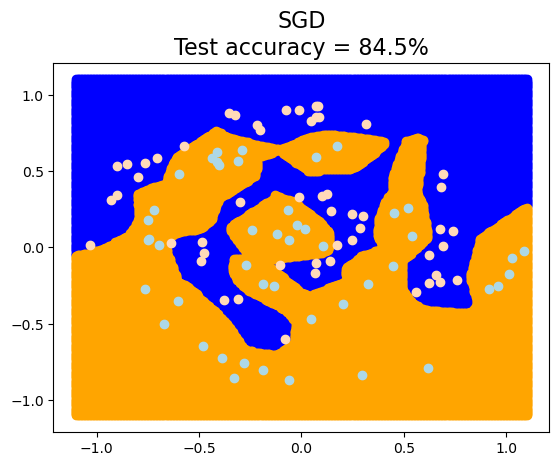

In [23]:
import numpy as np
import matplotlib.pyplot as plt

tar_boolean = (tar >= 0.5)
plt.plot(span[0,tar_boolean], span[1,tar_boolean],'o', c = 'b') #'#FF0000''b'
plt.plot(span[0,~tar_boolean], span[1,~tar_boolean],'o', c = 'orange')#'#0000FF''orange'
#plt.plot(x2, y2,'o',color="red")  # Add label to each plot

for features, target in TrainDataSet:
    if target == 0:
        plt.scatter(features[0], features[1], c='#ADD8E6', label='Class 0',zorder=10)#'#ADD8E6'
    else:
        plt.scatter(features[0], features[1], c = '#FFDAB9', label='Class 1',zorder=10)#'#FFDAB9'

#plt.title(f'SGD\nTrain accuracy = {100}%',fontsize=16)
plt.title(f'SGD\nTest accuracy = {84.5}%',fontsize=16)
#plt.savefig('NeuralNetworkFigures/SGD_NN_Test_Overlay.eps', format='eps')    
plt.show()

In [1]:
acc2_graph[-1]

NameError: name 'acc2_graph' is not defined

In [19]:
acc2_graph[-1]

array([0.54      , 0.59631579, 0.60789474, ..., 0.84578947, 0.84315789,
       0.84526316])